In [ ]:
# source
# https://machinelearningmastery.com/what-is-bayesian-optimization/

In [5]:
# load libraries
from math import sin
from math import pi
from numpy import arange
from numpy import argmax
from numpy.random import normal
from matplotlib import pyplot

Test Problem

The first step is to define a test problem.

We will use a multimodal problem with five peaks, calculated as:

y = x^2 * sin(5 * PI * x)^6
Where x is a real value in the range [0,1] and PI is the value of pi.

We will augment this function by adding Gaussian noise with a mean of zero and a standard deviation of 0.1. This will mean that the real evaluation will have a positive or negative random value added to it, making the function challenging to optimize.

The objective() function below implements this.

In [6]:
# objective function
def objective(x, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return (x**2 * sin(5 * pi * x)**6.0) + noise

We test this function by first defining a grid-based sample, 
with inputs from 0 to 1 and a step size of 0.01 across the domain.

In [7]:
# grid-based sample of the domain [0,1]
X = arange(0, 1, 0.01)

We can then evaluate these samples using the target function;
Noise excluded to see what the real objective function looks like.

In [8]:
# sample the domain without noise
y = [objective(x, 0) for x in X]

Here, generate objective function with noise

In [11]:
# sample the domain with noise
ynoise = [objective(x) for x in X]

We can look at all of the non-noisy objective function values to find the input that resulted in the best score and report it. This will be the optima, in this case, maxima, as we are maximizing the output of the objective function.

In practice, this would not be known. But for test problem, it is good to know the real best input and output of the function to compare to Bayesian Optimization results.

In [12]:
# find best result
ix = argmax(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))

Optima: x=0.900, y=0.810


Next we plot, showing the noisy samples (dots) and the true shape function (line).

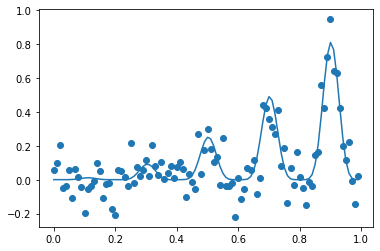

In [16]:
# plot the points with noise
pyplot.scatter(X, ynoise)
# plot the points without noise
pyplot.plot(X, y)
# show the plot
pyplot.show()

#### Surrogate Function

Now that we have a test problem, let’s review how to train a surrogate function.

The surrogate function is a technique used to best approximate the mapping of input examples to an output score.

Probabilistically, it summarizes the conditional probability of an objective function (f), given the available data (D) or P(f|D).

A Gaussian Process, or GP, is a model that constructs a joint probability distribution over the variables, assuming a multivariate Gaussian distribution. As such, it is capable of efficient and effective summarization of a large number of functions and smooth transition as more observations are made available to the model.

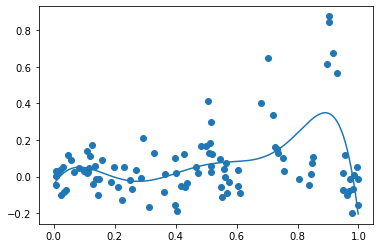

In [17]:
# example of a gaussian process surrogate function

# load libraries
from math import sin
from math import pi
from numpy import arange
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from matplotlib import pyplot
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor
 
# objective function
def objective(x, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return (x**2 * sin(5 * pi * x)**6.0) + noise
 
# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)
 
# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()
 
# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot the surrogate function
plot(X, y, model)

In this case, as  expected, the plot crudely resembles the underlying objective function, 
with a clear peak around the 0.9 input point, where we know the true maxima is located.

#### Acquisition Function

Next, we must define a strategy for sampling the surrogate function.

The surrogate function is used to test a range of candidate samples in the domain.

From these results, one or more candidates can be selected and evaluated with the real, and in normal practice, computationally expensive cost function.

This involves two pieces: the search strategy used to navigate the domain in response to the surrogate function and the acquisition function that is used to interpret and score the response from the surrogate function.

Here, we use a random sampling the domain. BFGS is the popular and preferred alternative.

Random sampling involves 
1. first drawing a random sample from the domain, 
2. evaluating them with the acquisition function, 
3. then maximizing the acquisition function to find the sample that gives the best score. 

In [19]:
# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(100)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]

The acquisition function is responsible for scoring or estimating the likelihood that a given candidate sample (input) is worth evaluating with the real objective function.

We could just use the surrogate score directly. Alternately, given that we have chosen a Gaussian Process model as the surrogate function, we can use the probabilistic information from this model in the acquisition function to calculate the probability that a given sample is worth evaluating.

There are many different types of probabilistic acquisition functions that can be used, each providing a different trade-off for how exploitative (greedy) and explorative they are.

Three common examples include:

Probability of Improvement (PI).
Expected Improvement (EI).
Lower Confidence Bound (LCB).
The Probability of Improvement method is the simplest, whereas the Expected Improvement method is the most commonly used.

Here, we implement the Probability of Improvement method, 
which is the normal cumulative probability of the normalized expected improvement:

* PI = cdf((mu – best_mu) / stdev)

1. PI is the probability of improvement, 
2. cdf() is the normal cumulative distribution function, 
3. mu is the mean of the surrogate function for a given sample x, 
4. stdev is the standard deviation of the surrogate function for a given sample x,  
5. best_mu is the mean of the surrogate function for the best sample found so far

A very small number is added to the standard deviation to avoid a divide by zero error.

The acquisition() function below implements in the context of previously defined work.

In [20]:
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (std+1E-9))
	return probs

#### Complete Bayesian Optimization Algorithm

Involves iterative: sampling, evaluation via objective function, updating of the GP model.

In [ ]:
# perform the optimization process
for i in range(100):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	# sample the point
	actual = objective(x)
	# summarize the finding for our own reporting
	est, _ = surrogate(model, [[x]])
	print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
	# add the data to the dataset
	X = vstack((X, [[x]]))
	y = vstack((y, [[actual]]))
	# update the model
	model.fit(X, y)

Here is the complete example

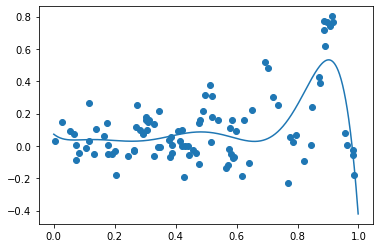

>x=0.897, f()=0.531006, actual=0.713
>x=0.552, f()=0.069979, actual=-0.038
>x=0.885, f()=0.532419, actual=0.799
>x=0.903, f()=0.566992, actual=0.710
>x=0.958, f()=0.305811, actual=-0.040
>x=0.665, f()=0.020894, actual=0.087
>x=0.358, f()=0.050982, actual=0.060
>x=0.899, f()=0.561661, actual=0.889
>x=0.416, f()=0.074810, actual=0.001
>x=0.900, f()=0.582974, actual=0.712
>x=0.858, f()=0.507605, actual=0.265
>x=0.972, f()=0.093568, actual=-0.117
>x=0.899, f()=0.577266, actual=0.566
>x=0.912, f()=0.565920, actual=0.747
>x=0.367, f()=0.051846, actual=-0.026
>x=0.900, f()=0.586422, actual=0.857
>x=0.464, f()=0.085185, actual=0.247
>x=0.363, f()=0.050756, actual=0.036
>x=0.175, f()=0.035789, actual=0.201
>x=0.647, f()=0.016422, actual=0.005
>x=0.899, f()=0.600885, actual=0.841
>x=0.175, f()=0.045549, actual=0.030
>x=0.551, f()=0.070127, actual=-0.055
>x=0.001, f()=0.054293, actual=-0.125
>x=0.928, f()=0.552723, actual=0.475
>x=0.698, f()=0.024704, actual=0.439
>x=0.898, f()=0.606157, actual=0

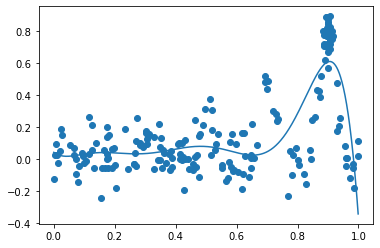

Best Result: x=0.906, y=0.891


In [22]:
# example of bayesian optimization for a 1d function from scratch
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
 
# objective function
def objective(x, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return (x**2 * sin(5 * pi * x)**6.0) + noise
 
# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)
 
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (std+1E-9))
	return probs
 
# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(100)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]
 
# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()
 
# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)
# perform the optimization process
for i in range(100):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	# sample the point
	actual = objective(x)
	# summarize the finding
	est, _ = surrogate(model, [[x]])
	print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
	# add the data to the dataset
	X = vstack((X, [[x]]))
	y = vstack((y, [[actual]]))
	# update the model
	model.fit(X, y)
 
# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

Here, all 200 samples evaluated during the optimization task are plotted. 
We see an overabundance of sampling around the known optima, as expected.
We also see that the surrogate function has a stronger alignment with the underlying data.

#### Hyperparameter Tuning With Bayesian Optimization

In Machine Learning, Bayesian Optimization is often used for hyperparameter tuning. 
This is because the evaluation function is computationally expensive (e.g. one model for each set of hyperparameters) and noisy (e.g. noise data and stochastic learning algorithms).

In [25]:
# If needed, install scikit-optimize which is an off the shelf solution for SciPy/NumPy
import sys
!{sys.executable} -m pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 957.8 kB/s eta 0:00:00a 0:00:01


In [26]:
# example of bayesian optimization with scikit-optimize
from numpy import mean
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2)
# define the model
model = KNeighborsClassifier()
# define the space of hyperparameters to search
search_space = [Integer(1, 5, name='n_neighbors'), Integer(1, 2, name='p')]
 
# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
	# something
	model.set_params(**params)
	# calculate 5-fold cross validation
	result = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='accuracy')
	# calculate the mean of the scores
	estimate = mean(result)
	return 1.0 - estimate
 
# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))

/usr/local/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has be

/usr/local/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has be

/usr/local/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has be

Best Accuracy: 1.000
Best Parameters: n_neighbors=5, p=2


Here, the model achieved 100% accuracy via 5-fold cross-validation and a p-value of 2.